<ipython-input-1-cf333d9a0fae>:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10_df[material] = percentage * (1.85/60) * top_10_df['TOTAL']


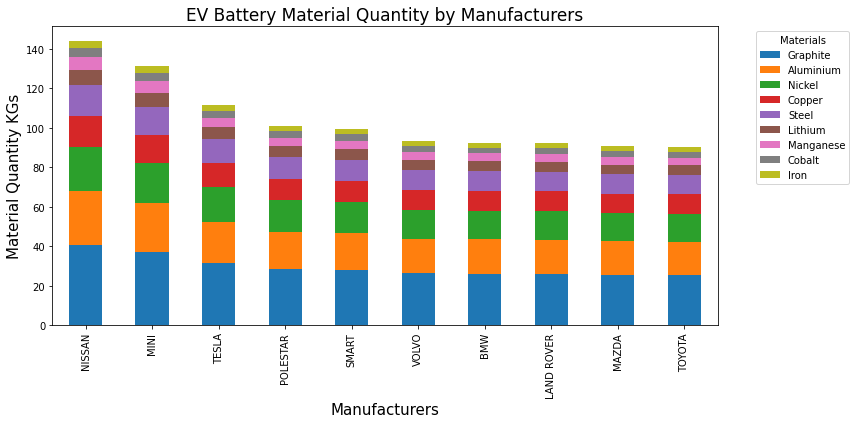

In [1]:
####### 5_4 Battery Component Weights by OEM  ################
import pandas as pd
import matplotlib.pyplot as plt

# Replace 'url_to_your_csv_file' with the raw GitHub URL of your CSV file
csv_url = r'https://raw.githubusercontent.com/varunraaju/Battery_Cycle_Plots/main/5_4/VEH0171b_GenModels.csv?token=GHSAT0AAAAAACFKR6ACWP5DXT6XXWYZY47UZGI53AQ'

# Read the CSV file into a DataFrame, skipping the first 4 rows
df = pd.read_csv(csv_url, skiprows=4)

# Save the first four columns in a separate DataFrame with the renamed names
first_four_columns = df.iloc[:, :6].rename(columns={df.columns[2]: 'BODY TYPE', df.columns[3]: 'MAKE', df.columns[4]: 'MODEL', df.columns[5]: 'FUEL'})

# Drop the first two columns from the original DataFrame
df.drop(df.columns[:4], axis=1, inplace=True)

# Create a new DataFrame to store the sums
sum_df = pd.DataFrame(index=df.index)

# Iterate through columns and group by left 4 characters of the header
for col in df.columns:
    header_prefix = col[:4]
    if header_prefix not in sum_df.columns:
        selected_columns = df.loc[:, df.columns.str[:4] == header_prefix]
        sum_df[header_prefix] = pd.to_numeric(selected_columns.stack(), errors='coerce').groupby(level=0).sum()

# Print the first few rows of the new DataFrame with sums and the first four columns unchanged
result_df = pd.concat([first_four_columns, sum_df], axis=1)
new_df = result_df.drop(result_df.columns[[0, 1, 6, 7]], axis=1)

# Calculate the sum of numbers from the 5th column till the last column and add a new "TOTAL" column
new_df['TOTAL'] = new_df[new_df.columns[2:]].sum(axis=1)

# Filter out rows where 'MODEL' column contains the string "MISSING"
clean_data = new_df[~new_df['MODEL'].str.contains("MISSING")]

##################################################################
# Manually replace the EV battery capacity data file path

csv_url2 = r'https://raw.githubusercontent.com/varunraaju/Battery_Cycle_Plots/main/5_4/EV_CAPACITY.csv?token=GHSAT0AAAAAACFKR6ACWNH3YVW4VOSXMYDCZGI52WQ'
df2 = pd.read_csv(csv_url2)
df2.columns = df2.columns.str.upper()
# print(df2)
###################################################################
# merging both the data frames
clean_data = clean_data.merge(df2[['MODEL', 'BODY_TYPE', 'CAPACITY_KWH']], on='MODEL', how='left')

# Drop rows with NaN values in the 'BODY_TYPE' column
clean_data.dropna(subset=['BODY_TYPE'], inplace=True)

# List of body types to categorize
main_body_types = ['Sedan', 'SUV', 'Hatchback', 'Van']

# Categorize 'BODY TYPE' column as Sedan, SUV, Hatchback, Van, and "Others"
clean_data['BODY_TYPE_CATEGORIZED'] = clean_data['BODY_TYPE'].where(clean_data['BODY_TYPE'].isin(main_body_types), 'Others')
########################################################################
clean_data['TOTAL_CAPACITY'] = clean_data['CAPACITY_KWH']* clean_data['TOTAL']

# Group by "MAKE" and calculate the grouped "TOTAL"
grouped_df = clean_data.groupby('MAKE')['TOTAL'].mean().reset_index()

# Sort the rows in descending order of "TOTAL"
grouped_df = grouped_df.sort_values(by='TOTAL', ascending=False)

# Keep only the top ten rows
top_10_df = grouped_df.head(10)

# Display the top 10 rows
# print(top_10_df)
###############################################################

# Materials and percentages from the previous DataFrame
materials = ['Graphite', 'Aluminium', 'Nickel', 'Copper', 'Steel', 'Lithium', 'Manganese', 'Cobalt', 'Iron']
percentages = [0.281, 0.189, 0.157, 0.108, 0.108, 0.054, 0.043, 0.032, 0.027]

# Calculate the new values for each material in the top_10_df
for material, percentage in zip(materials, percentages):
    top_10_df[material] = percentage * (1.85/60) * top_10_df['TOTAL']

# Display the updated top_10_df with new columns
top_10_df = top_10_df.drop('TOTAL', axis=1)
# print(top_10_df)

# Set 'MAKE' column as index for easier plotting
top_10_df.set_index('MAKE', inplace=True)

# Plot the stacked bar graph
ax = top_10_df.plot.bar(stacked=True, figsize=(12, 6))
ax.set_ylabel("Material Quantity KGs",fontsize=15)
ax.set_xlabel("Manufacturers",fontsize=15)
ax.set_title("EV Battery Material Quantity by Manufacturers",fontsize=17)
plt.legend(title="Materials", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

